In [1]:
!pip install seaborn scikit-learn

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

plt.rcParams["figure.figsize"] = (10, 6)
sns.set(style="whitegrid")

In [3]:
# Leicester city centre coordinates (same as your scripts)
lat = 52.629729
lng = -1.131592

url = "https://data.police.uk/api/crimes-street/all-crime"
params = {"lat": lat, "lng": lng}

response = requests.get(url, params=params)
response.raise_for_status()
data = response.json()

len(data)

1477

In [4]:
records = []
for r in data:
    loc = r.get("location") or {}
    row = {
        "category": r.get("category"),
        "month": r.get("month"),
        "latitude": float(loc.get("latitude")) if loc.get("latitude") else None,
        "longitude": float(loc.get("longitude")) if loc.get("longitude") else None,
        "street_name": (loc.get("street") or {}).get("name"),
        "crime_id": r.get("id"),
        "outcome_status": (r.get("outcome_status") or {}).get("category"),
    }
    records.append(row)

df = pd.DataFrame(records)
df.head()

,category,month,latitude,longitude,street_name,crime_id,outcome_status
0,anti-social-behaviour,2025-09,52.635797,-1.131926,On or near Fox Lane,131032513,None
1,anti-social-behaviour,2025-09,52.620909,-1.116031,On or near St Marys Road,131033113,None
2,anti-social-behaviour,2025-09,52.629772,-1.132917,On or near Parking Area,131032608,None
3,anti-social-behaviour,2025-09,52.621821,-1.138165,On or near Sports/recreation Area,131033114,None
4,anti-social-behaviour,2025-09,52.632534,-1.133232,On or near Market Street,131033115,None


In [5]:
print("Rows:", len(df))
print(df.isna().mean().sort_values(ascending=False).head(10))
df["category"].value_counts().head(10)

Rows: 1477
outcome_status    0.134056
month             0.000000
category          0.000000
latitude          0.000000
longitude         0.000000
street_name       0.000000
crime_id          0.000000
dtype: float64


,count
category,
violent-crime,409
anti-social-behaviour,198
public-order,178
shoplifting,145
vehicle-crime,114
criminal-damage-arson,109
other-theft,104
drugs,69
burglary,46


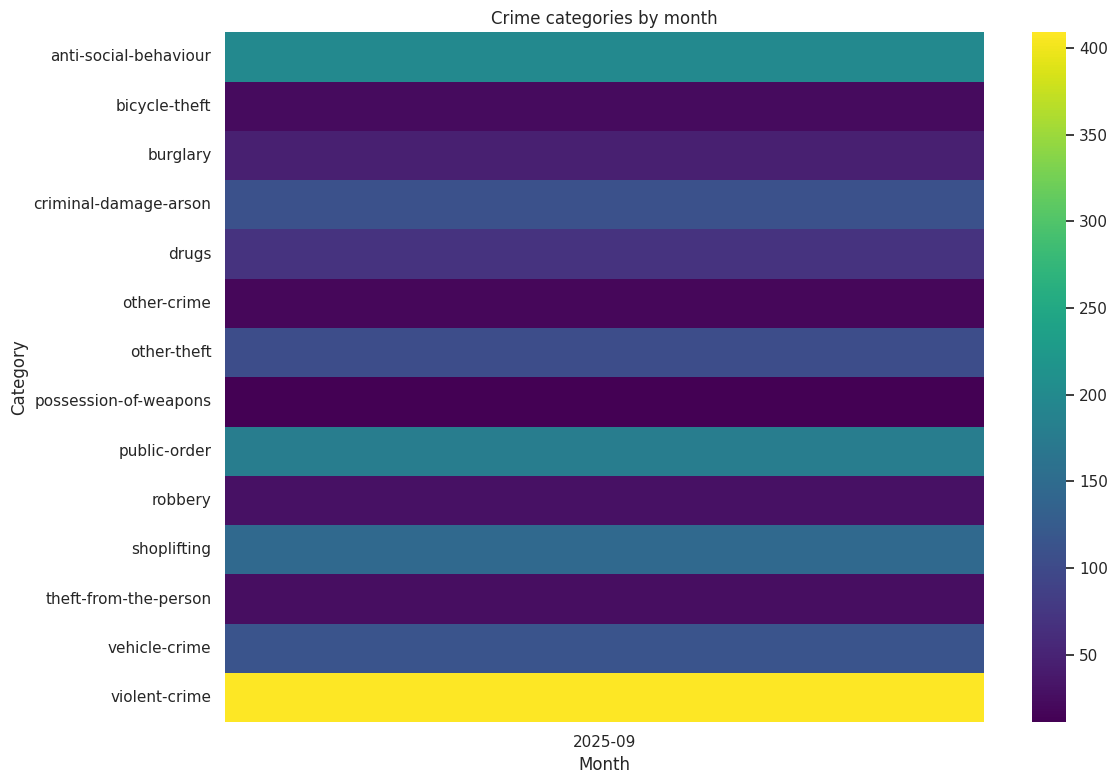

In [6]:
# Pivot: rows = category, columns = month, values = count
cat_month = pd.crosstab(df["category"], df["month"])

plt.figure(figsize=(12, 8))
sns.heatmap(cat_month, cmap="viridis")
plt.title("Crime categories by month")
plt.ylabel("Category")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

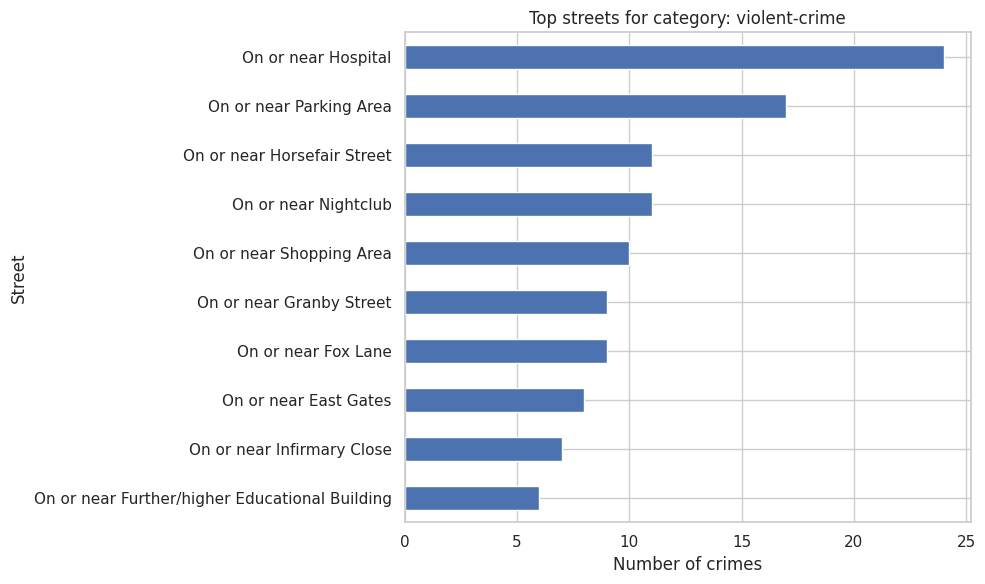

In [9]:
top_streets.sort_values().plot(kind="barh")
plt.title(f"Top streets for category: {target_category}")
plt.xlabel("Number of crimes")
plt.ylabel("Street")
plt.tight_layout()
plt.show()

In [12]:
# Drop rows without coordinates
df_coords = df.dropna(subset=["latitude", "longitude"]).copy()

X = df_coords[["latitude", "longitude"]]

k = 5  # number of clusters (you can play with this)
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_coords["cluster"] = kmeans.fit_predict(X)

df_coords.head()

,category,month,latitude,longitude,street_name,crime_id,outcome_status,cluster
0,anti-social-behaviour,2025-09,52.635797,-1.131926,On or near Fox Lane,131032513,None,0
1,anti-social-behaviour,2025-09,52.620909,-1.116031,On or near St Marys Road,131033113,None,2
2,anti-social-behaviour,2025-09,52.629772,-1.132917,On or near Parking Area,131032608,None,1
3,anti-social-behaviour,2025-09,52.621821,-1.138165,On or near Sports/recreation Area,131033114,None,1
4,anti-social-behaviour,2025-09,52.632534,-1.133232,On or near Market Street,131033115,None,0


In [13]:
cluster_category = (
    df_coords.groupby(["cluster", "category"])
    .size()
    .reset_index(name="count")
    .sort_values(["cluster", "count"], ascending=[True, False])
)

cluster_category.head(20)

,cluster,category,count
12,0,violent-crime,125
0,0,anti-social-behaviour,66
7,0,public-order,59
9,0,shoplifting,52
5,0,other-theft,31
11,0,vehicle-crime,31
3,0,criminal-damage-arson,24
4,0,drugs,18
2,0,burglary,13
10,0,theft-from-the-person,11
